### Purpose
The purpose of this code is to reproduce the response of a superconducting quantum interference device (SQUID) by numerical simulation. We will numerical method, namely Runge-Kutta 4th order fixed-time step modified to accept a noise signal, to simulate the average voltage response of a pair of resistively shunted Josephson junctions in parrallel, with Johnson noise in the shunt. We wish to make the model dependent on physical parameters of the circuit (critical current and symmetry considerations in shunt resistance and branch inductances) and dependent on input parameters as the applied flux and bias current placed across the circuit. This model will be useful in basic investigation of circuit behavior and in fitting physical parameters to real circuits
![2ndvsurf](2ndvsurf.jpg)

### The Model
The model used here is from Tesche-Clarke 1977, section 2. The model is developed by combining the Josephson effects of two resistively shunted Josephson junctions arranged on a superconductiong ring. The junctions are in parrallel with respect to the bias current and voltage across the circuit.
![squid_circuit.jpg](squid_circuit.jpg)
Having combined effects and converte to dimensionless units, the needed system of equations is found to be:

$$j = (\delta_1 - \delta_2 - 2\pi\phi_a)/\pi \beta{}_L - \eta i /2$$

$$v = \frac{1+\eta}{2}\frac{d\delta_1}{d\theta} + \frac{1-\eta}{2}\frac{d\delta_2}{d\theta}$$

$$\frac{d^2\delta_1}{d\theta^2} = \frac{i/2-j-(1-\alpha)\sin{\delta_1}-(1-\rho)\frac{d\delta_1}{d\theta}}{(1-\kappa)\beta_C}$$

$$\frac{d^2\delta_2}{d\theta^2} = \frac{i/2+j-(1+\alpha)\sin{\delta_2}-(1-\rho)\frac{d\delta_2}{d\theta}}{(1+\kappa)\beta_C}$$

$$\frac{d\delta_1}{d\theta} = \frac{i/2 - j-(1-\alpha)\sin{\delta_1}-(1-\kappa)\beta_C \frac{d^2\delta_1}{d\theta^2}}{1-\rho} + v_{N1}$$

$$\frac{d\delta_2}{d\theta} = \frac{i/2 - j-(1+\alpha)\sin{\delta_2}-(1+\kappa)\beta_C \frac{d^2\delta_2}{d\theta^2}}{1+\rho} + v_{N2}$$

#### Parameters

$I_0$ - critical current of each junction

$\Phi_0$ - flux quantum

$R$ - total resistance of circuit (shunts)

$\theta$ - dimensionless time [$\Phi_0/2\pi I_0 R$]

$j$ - circulating current in superconducting ring [$I_0$]

$\delta_{1,2}$ - phase difference across each junction

$\phi_a$ - applied flux [$\Phi_0$]

$\eta$ - inductance symmetry parameter (0 to 1)

$v$ - voltage across circuit [$I_0 R$]

$i$ - applied bias current [$I_0$]

$\alpha$ - critical current symmetry parameter (0 to 1)

$\rho$ - resistance symmetry parameter (0 to 1)

$\kappa$ - capacitance symmetry paramter (0 to 1)

$\beta_L$ - inductance constant

$\beta_C$ - capacitance constant

$v_{N1,2}$ - noise signal, random Gaussian distributed voltage value [$I_0 R$]

This model considers the Johnson noise in the resistive shunts. This effect is temperature dependent and can be described by the parameter $\Gamma$, which is temperature dependent. The value will be supplied by the user for our model rather than derived. The random, Gaussian distributed voltage noise values have average value 0 and standard deviation* $\sigma_{v_N}=\sqrt{2\Gamma/\Delta\theta}$. (more on this in the numrical method section)

### Numerical Method
#### Modified Runge-Kutta 4th order, fixed-time step

We will use a modified RK4 fixed-time step method to solve the time series voltage output for the system. The fixed step size is chosen to simplify the modification of the method to utilize the noise signals, $v_{N1,2}$. The RK4 method will use half-time steps, meaning the method will calculate values at the current moment, halfway to the next time output, and at the next time point to output the value at the next time point. At the first iteration, the method will use $t_0, t_{1/2}, t_1$ to output $v_1$. Then, it will use $t_1, t_{3/2}, t_2$ to output $v_2$. Then we need to keep track of and pass noise values $v_n$ such that the RK4 method has available $v_0, v_1, v_2$ at $t_0$ to return $v_1$ and then pass $v_2, v_3, v_4$ at $t_1$ to return $v_2$, and so on.

Because we are creating and using twice as many noise values as voltage outputs, we need to modify the standard deviation quoted above in the model section. Since each noise value occurs at a half time step, we have

$$\sigma_{v_N} = \sqrt{\frac{2\Gamma}{\frac{\Delta \theta}{2}} }=\sqrt{ \frac{4\Gamma}{\Delta \theta}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import interpolate
import csv
import datetime

#design output
#v=0 critical current v stuff
#time series for quiet squid
#time series for d

The code below is merely to include a progress bar in long calculations later.

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

#### Modified RK4
Here we employ a standard RK4 method modified to pass noise values to the derivative function at each iteration. We need to pass three noise values for each junction at each iteration, namely the present time noise values, the values at a half-time step away, and the values at a full time step away. We have to supply the correct values at each iteration, meaning the last pair of noise values passed for the present iteration must also be the first set of noise values passed at the next iteration. We simply define those as supplied parameters to the solver, and let them drop through to the derivative functions as appropriate.

For the purposes of this notebook, I have left all input parameters as scalars rather than combine them as vectors where it may be more concise.

In [3]:
def noisyRK4(s,th,tau,derivsRK,par,vn10,vn20,vn11,vn21,vn12,vn22):
    """RK4 integrator modified to use noise
    DEPENDENCIES
        derivsRK - RHS of ODE, fn defined somewhere
    INPUTS
        s - state vector
        th - time, theta
        tau - time step size
        derivsRK - RHS of ODE, fn defined somewhere
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
    OUTPUTS
        sout - new state vector new time
            [delta_1,delta_2,ddelta_1,ddelta_2,d^2delta_1,d^2delta_2]"""
    
    # parse out parameter array
    alpha = par[0]; beta = par[1]; eta = par[2]
    rho = par[3]; i = par[4]; phia = par[5]; Gamma=par[6]
    betaC=par[7]; kappa=par[8]
    
    # noisySQUIDrk(s,th,alpha,beta,eta,rho,i,phia,vn1,vn2)
    
    half_tau = 0.5*tau
    
    F1 = derivsRK(s,th,par,vn10,vn20)             # use current voltage noise
    th_half = th + half_tau
    stemp = s + half_tau*F1
    
    F2 = derivsRK(stemp,th_half,par,vn11,vn21)    # use half-tau step voltage noise
    stemp = s + half_tau*F2
    
    F3 = derivsRK(stemp,th_half,par,vn11,vn21)    # use half-tau step voltage noise
    th_full = th + tau
    stemp = s + tau*F3
    
    F4 = derivsRK(stemp,th_full,par,vn12,vn22)    # use full-tau step voltage noise
    sout = s + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return sout   

The function below is called by the modified RK4 above. It returns the calculated value of the derivative at a half-time step away or a full time step away as requested by the RK4. Noise values fall through from the RK4 to the function below.

In [4]:
def noisySQUIDrk(s,th,par,vn1,vn2):
    """Returns RHS of ODE
    DEPENDENCIES
        numpy as np
    INPUTS
        s - state vector [del1(theta), del2(theta)]
        th - time, theta
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
            alpha - critical current symmetry parameter (0 to 1)
            beta - inductance constant
            eta - inductance symmetry parameter (0 to 1)
            rho - resistance symmetry parameter (0 to 1)
            i - dimensionless bias current
            phia - dimensionless applied flux
            Gamma - Johnson noise parameter
            betaC - capacitance constant
            kappa - capacitance symmetry parameter
        nv1,nv2 - noise values at each junction
    OUTPUTS
        deriv - array 
            [ddel1/dth, ddel2/dth, d^2del1/dth^2, d^2del2/dth^2]"""
    # parse out parameter array
    alpha = par[0]; beta = par[1]; eta = par[2]
    rho = par[3]; i = par[4]; phia = par[5]; Gamma=par[6]
    betaC=par[7]; kappa=par[8]
    #del1 = s[0] # del_1(theta)
    #del2 = s[1] # del_2(theta)
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    
    dddel1 = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-rho)*s[2])/((1-kappa)*betaC)
    dddel2 = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+rho)*s[3])/((1+kappa)*betaC)
        
    ddel1 = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-kappa)*betaC*dddel1)/(1-rho) + vn1 # ddel1/dth
    ddel2 = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+kappa)*betaC*dddel2)/(1+rho) + vn2 # ddel2/dth
    
    deriv = np.array([ddel1,ddel2,dddel1,dddel2])
    return(deriv)

We need a function to handle the solver. We need the handler to accept simulation parameters (number of steps, step size, initial conditions, physical parameters), create a set of noise values, create a data structure and populate with initial conditions. Then call the RK4 solver within a loop and store the output in an array which will be returned to the user.

In [5]:
def noisySQUID(nStep,tau,s,par):
    """Handles RK4 solver, returns time series sim of SQUID
    DEPENDENCIES
        noisySQUIDrk - modified RK4 solver
        numpy as np
    INPUTS
        nStep - number of steps
        tau - time step size
        s - initial state vector
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
            alpha - critical current symmetry parameter (0 to 1)
            beta - inductance constant
            eta - inductance symmetry parameter (0 to 1)
            rho - resistance symmetry parameter (0 to 1)
            i - dimensionless bias current
            phia - dimensionless applied flux
            Gamma - Johnson noise parameter
            betaC - capacitance constant
            kappa - capacitance symmetry parameter
    OUTPUTS
        S - time series state vector
            [theta,delta_1,delta_2,j,ddel1/dth,ddel2/dth,v]"""
    #parse out the parameter vector
    alpha=par[0]; betaL=par[1]; eta=par[2]; rho=par[3]
    i=par[4]; phia=par[5]; Gamma=par[6]; betaC=par[7]
    kappa=par[8]
    # change state vector s to include all the derivs
    # little s denotes a 1-d vector of, current values
    # big S denotes the output array of all s, a 2-d array in time
    ## NOISE ##
    # set an appropriate variance based on Gamma.
    # variance is twice normal because freq of noise
    # is twice that of the sampling freq so that rk4 has
    # a noise value to use at each half tau step
    var = 4*Gamma/tau
    sd = var**.5
    
    # make two time series of noise voltages
    # lowercase designators are current values, uppercase are arrays in time
    VN1 = np.zeros(2*nStep+1)
    VN2 = np.zeros(2*nStep+1)
    for ist in range(2*nStep+1):
        VN1[ist] = np.random.normal(0,sd)
        VN2[ist] = np.random.normal(0,sd)
    
    # DATA STRUCTURE
    # S = [theta,del1,del2,ddel1,ddel2,dddel1,dddel2,j,v]
    S = np.zeros([8,nStep],float)
    # set initial conditions
    theta = 0.
    S[0,0] = theta
    S[1,0] = s[0] # del1
    S[2,0] = s[1] # del2
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    S[3,0] = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-kappa)*betaC*s[4])/(1-rho) # ddel1
    S[4,0] = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+kappa)*betaC*s[5])/(1+rho) # ddel2
    S[5,0] = (.5*i-j-(1-alpha)*np.sin(s[0])-(1-rho)*s[2])/((1-kappa)*betaC) # dddel1
    S[6,0] = (.5*i+j-(1+alpha)*np.sin(s[1])-(1+rho)*s[3])/((1+kappa)*betaC) # dddel2
    
    s = np.copy(S[1:5,0])
    
    for iStep in range(1,nStep):
        vn10 = VN1[2*iStep-2]
        vn20 = VN2[2*iStep-2]
        vn11 = VN1[2*iStep-1]
        vn21 = VN2[2*iStep-1]
        vn12 = VN1[2*iStep]
        vn22 = VN2[2*iStep]
        
        #   noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22)
        s = noisyRK4(s,theta,tau,noisySQUIDrk,par,vn10,vn20,vn11,vn21,vn12,vn22)
        
        S[0,iStep] = theta # time theta
        S[1,iStep] = s[0] # del1
        S[2,iStep] = s[1] # del2
        S[3,iStep] = s[2] # ddel1
        S[4,iStep] = s[3] # ddel2
        
        #S[5,iStep] =  # dddel1
        #S[6,iStep] =  # dddel2
        
        theta = theta + tau
        
    # S[5,:] = 
    # S[6,:] = 
    S[6] = S[3]*(1+eta)/2  + S[4]*(1-eta)/2
        
    return(S)    

Now we can test the time series output. Define all the simulation and physical parameters, build a parameter array.

In [6]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 8000
tau = 0.1
s = np.array([0.,0.,0.,0.,0.,0.])
alpha = 0.
betaL = 1.
betaC = 1.
kappa = 0.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05

par = np.array([alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa])

Call the function handler, pass the parameters, store as new array, SQ.

In [7]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
SQ = noisySQUID(nStep,tau,s,par)

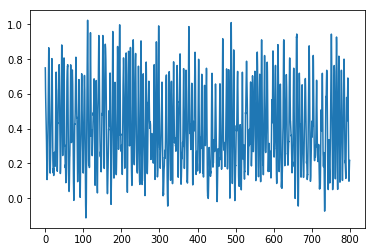

In [8]:
plt.plot(SQ[0,],SQ[6,])

We need a utility to output a plot of the timeseries data, and save out a csv and the plot. These are both stored in the parent folder.

In [9]:
def vj_timeseries(nStep,tau,s,par):
    """Returns time series simulation of squid, figure and csv
    DEPENDENCIES
    qSQUID()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
    OUTPUTS
        figure - plots of
            voltage time series w average
            circulating current time series w average
            output to screen
            png 'timeseriesdatetime.png' saved to parent directory
        csv - time series csv file containing
            theta,delta_1,delta_2,j,ddel1/dth,ddel2/dth,v
            csv 'timeseriesdatetime.csv' saved to parent directory            
        """
    # run sim
    S = noisySQUID(nStep,tau,s,par)
    # chop off first 10% of time series to remove any transient
    md = int(.1*len(S[0,:]))
    
    # build figure title with parameters used
    ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s'% (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)))+'\n'+\
            r'$\rho$=%s, $i$=%s, $\phi_a$=%s' % (str(round(par[3],3)),str(round(par[4],3)),str(round(par[5],3)))+'\n'+\
            r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
    
    # plot
    fig, ax = plt.subplots(2,1,figsize=(3,7))
    fig.suptitle(ti)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(S[0,md:],S[6,md:])
    ax1.hlines((sum(S[6,md:])/len(S[6,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax1.set(ylabel="Voltage, v",
       xticklabels=([]))
    ax2 = plt.subplot(2,1,2)
    ax2.plot(S[0,md:],S[3,md:])
    ax2.hlines((sum(S[3,md:])/len(S[3,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax2.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$")
    
    # create output file metadata    
    meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    header = ['theta','delta_1','delta_2','j','ddel1/dth','ddel2/dth','v']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='timeseries'+timeti+'.csv'
    pngtitle='timeseris'+timeti+'.png'
    Sf = np.matrix.transpose(S)
    
    # create, write, output(close) csv file
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

#### How to build Timeseries

The function **vj_timeseries()** gives a plot of voltage and circulating currents as functions of time, and a csv timeseries output of the state vector describing the SQUID, including **theta**, **delta_1**, **delta_2**, **j**, **ddel1/dth**, **ddel2/dth** and **v**. Note that there is not a phisical instrumentation equivalent of this investigation as the oscillations observed in the simulation are much faster than can be observed phisically. The physical observation we can make is the average value of the high frequency oscillations that occur in the physical SQUID. For this reason, we are typically interested in the average value, say the average value of the output voltage. This routine plots the average value over the time series.

To run the script, we need to supply the physical parameters and simulation prameters. This is done as below, by manually specifying each by defining a value or array.

The simulation parameters nStep and tau are supplied as an integer and a float respectively. As a practical matter, I have found **nStep**=80000 gives fine detail by averaging values over a long time series run, but these simulations can take several minutes to complete. A value of **nStep**=8000 gives fine enough detail to see representative behavior without taking as long to complete the simulation. To capture high frequency detail in the time series, I would recommend using **tau**=0.01. To run fast simulations to see where you are at, I recommend **tau**=0.1.

The initial state of the system is defined by the input **s**, an array of floats defining the initial phase differences at each junction. These initial phase values are somewhat arbitrary as the system will settle into a regular periodic behavior. Any average values used in the script have the first 10% of the time series removed to mitigate any transient response before this regular periodic behavior emerges.

The parameter array **par** is a float array describing **alpha**, **beta_L**, **eta**, **rho**, **i**, and **phia** in that order.

#### timeseries example

Imediately below is an example time series generation.

Assign a variable **nStep** an integer value. (start with 8000 to 80000)

Assign a varialbe **tau** a float value. (start with 0.01 to 0.1)

Assign a variable **s** an array of 2 floats describing the intitial phase differences.

Assign a variable **par** an array of float values representing the parameters desired. In this case, **alpha**=0., **beta_L**=1., **eta*=0., **rho**=.8, **i**=2.1, **phia**=0..

Call the routine, **vj_timeseries(nStep,tau,s,par)** to generate contours. A plot will be generated and saved to the parent directory, as well as a csv file.

Note that one could call the routine without explictly defining the parameters ahead of time by typing **vj_timeseries(80000,.01,np.array([0.,0.]),np.array([0.,1.,0.,0.8,2.1,0.]))** with the same result.

csv file written out: timeseries20191130225227.csv
png file written out: timeseris20191130225227.png


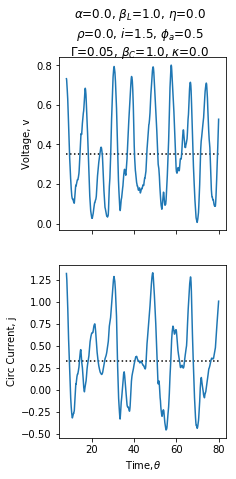

In [10]:
nStep = 8000
tau = 0.01
s = np.array([1.,0.,0.,0.,0.,0.])
alpha = 0.
betaL = 1.
betaC = 1.
kappa = 0.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05

par = np.array([alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa])

vj_timeseries(nStep,tau,s,par)

We want to investigate the average voltage surface, and the related transfer function. We want to investigate the effect of various physical parameters on these surfaces. One way to do that is to draw contours on the i-v plot and the v-phi plot. The contours will be definable, some range of values on one of the parameters.

These utilities will call the solver many times, once for each i over the range we are investigating, and the v-phi curve to come will do the same. This will take some time, so we will start to include the progress bar output.

First, the i-v curve.

In [11]:
def iv_curve(nStep,tau,s,par,alpha=0,betaL=0,eta=0,rho=0,phia=0,Gamma=0,betaC=0,kappa=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta_L, eta, rho, i, phia]
        input parameter LIST - alpha, beta, eta, rho, phia
            multiple values of input parameter as list
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input list here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create currents to sweep
    i = np.arange(0.,6.,.1)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(i)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,9])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=$s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],0.,par[5],par[6],par[7],par[8]])
        ch = ch + 1
    if betaL != 0:
        betaL = np.array(betaL)
        k = len(betaL)
        parj = np.zeros([k,9])
        la = r'$\beta_L$'; lc = 'betaL'
        lb = np.copy(betaL)
        ti = r'$\alpha$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=$s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],betaL[j],par[2],par[3],0.,par[5],par[6],par[7],par[8]])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,9])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=$s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],0.,par[5],par[6],par[7],par[8]])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,9])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=$s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],0.,par[5],par[6],par[7],par[8]])
        ch = ch + 1
    if phia != 0:
        phia = np.array(phia)
        k = len(phia)
        parj = np.zeros([k,9])
        la = r'$\phi_a$'; lc = 'phi_a'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
        r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,phia[j],par[6],par[7],par[8]])
        ch = ch + 1
    if Gamma != 0:
        Gamma = np.array(Gamma)
        k = len(Gamma)
        parj = np.zeros([k,9])
        la = r'$\Gamma$'; lc = 'Gamma'
        lb = np.copy(Gamma)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s, $\beta_C$=%s, $\kappa$=%s' % (par[0],par[1],par[2],par[3],par[5],par[7],par[8])                
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,par[5],Gamma[j],par[7],par[8]])
        ch = ch + 1
    if betaC != 0:
        betaC = np.array(betaC)
        k = len(betaC)
        parj = np.zeros([k,9])
        la = r'$\beta_C$'; lc = 'betaC'
        lb = np.copy(betaC)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
                r'$\phi_a$=$s, $\Gamma$=%s, $\kappa$=%s' %(str(round(par[5],3)),str(round(par[6],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,par[5],par[6],betaC[j],par[8]])
        ch = ch + 1
    if kappa != 0:
        kappa = np.array(kappa)
        k = len(kappa)
        parj = np.zeros([k,9])
        la = r'$\kappa$'; lc = 'kappa'
        lb = np.copy(kappa)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
                r'$\phi_a$=$s, $\Gamma$=%s, $\beta_C$=%s' %(str(round(par[5],3)),str(round(par[6],3)),str(round(par[7],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,par[5],par[6],par[7],kappa[j]])
        ch = ch + 1
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,9])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+ '\n' +\
                r'$\phi_a$=$s, $\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' % (str(round(par[5],3)),str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(i)])
    else:
        V = np.zeros([2,len(i)])
        
    # cp - check progress, total outputs in V
    cp = k*len(i)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(i)):
            parjj[4] = i[m]
            S = noisySQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(i))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(i),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(V[0],i)
        header = ['i','V']
    # k contours
    else:
        header = ['i']*(k+1)
        for j in range(k):
            ax.plot(V[j],i,label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    # ic = 0 line for comparison
    ax.plot(np.arange(0,2.6,.1),np.arange(0,5.2,.2),'--',
       label=r"$i_c=0$")
    ax.set(title=ti,
       xlabel=r"Average voltage, $\bar{v}$",
       ylabel="Bias current, i",
       xlim=[0,2.5],ylim=[0,6.])
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='IV'+timeti+'.csv'
    pngtitle='IV'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

#### Instructions for building IV contours

The function **iv_curve()** gives a singular or multiple contours of the transfer function as IV curves, bias current vs average voltage. This is similar to what we might see with the oscilloscope a physical SQUID.

To run the script, we need to supply the physical parameters and simulation prameters. This is done as below, by manually specifying each by defining a value or array.

The simulation parameters nStep and tau are supplied as an integer and a float respectively. As a practical matter, I have found **nStep**=80000 gives fine detail by averaging values over a long time series run, but these simulations can take several minutes to complete. A value of **nStep**=8000 gives fine enough detail to see representative behavior without taking as long to complete the simulation. To capture high frequency detail in the time series, I would recommend using **tau**=0.01. To run fast simulations to see where you are at, I recommend **tau**=0.1.

The initial state of the system is defined by the input **s**, an array of floats defining the initial phase differences at each junction. These initial phase values are somewhat arbitrary as the system will settle into a regular periodic behavior. Any average values used in the script have the first 10% of the time series removed to mitigate any transient response before this regular periodic behavior emerges.

To create contours, some parameter other than input current must be swept. The desired parameter to sweep is chosen by using its name to define a **LIST** of float values to sweep for that parameter. This input must be given in the form of a list. This parameter list will replace whatever value is given in the parameter array **par** described below. The appropriate names are **alpha**, **beta_L**, **eta**, **rho** and **phia**. Use around three values max as the processor time goes directly as the length of this list. **IF no array valued parameter is defined** the routine will use the value given in the parameter array **par** described below, and only one contour curve will be drawn.

The parameter array **par** is a float array describing **alpha**, **beta_L**, **eta**, **rho**, **i**, **phia**, **Gamma**, **betaC**, and **kappa** in that order. **NOTE**, the parameter **i** is redundant but a placeholder value must be in the parameter array anyway. The routine will sweep i automatically, from 0 to 6. As noted above, any parameter given as it's own list will overwrite the value given here, but a dummy value must be supplied here.

There may be numerical problems from dividing by a small number if **betaC** is zero or very small. If you can consider capicatance negligible, use the 1st order package **noisy_squid.py** instead of this one.

#### IV curve example

Imediately below is an example IV curve generation.

Assign a variable **nStep** an integer value. (start with 8000 to 80000)

Assign a varialbe **tau** a float value. (start with 0.01 to 0.1)

Assign a list of contour values. In this case, we want to sweep applied flux. We name a list **Phia** in this case. (Use somethig other than the routine's name for the parameter here, hence capitol **Phia**). This must be a list, not an array.

Assign a variable **par** an array of float values representing the parameters desired. In this case, **alpha**=0, **beta_L**=1, **eta*=0, **rho**=0, a placeholder 0 for **i**, and a placeholder 0.5 for **phia**, **Gamma**=.05, **betaC**=0.3, and **kappa**=.5.

Call the routine, **iv_curve(nStep,tau,s,par,phia=Phia)** to generate contours. A plot will be generated and saved to the parent directory, as well as a csv file.

Note that one could call the routine without explictly defining the parameters ahead of time by typing **iv_curve(8000,.01,np.array([1.,0.]),np.array([0.,1.,0.,0.,0.,0.5,.05,.3,.5]),phia=[0.,.25,.5])** with the same result.

Progress: [####################] 100.0%
csv file written out: IV20191130225911.csv
png file written out: IV20191130225911.png


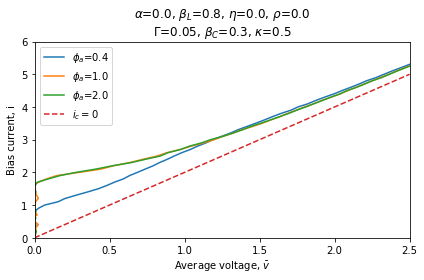

In [12]:
nStep = 8000
tau = 0.1
s = np.array([1.,0.,0.,0.,0.,0.])
alpha = 0.
betaL = 0.8
betaC = .3
kappa = .5
eta = 0.
rho = 0.
i = 2.1
phia = 0.5
Gamma = 0.05

# parameter contour must be a list, not array
Phi = [.4,1.,2.]

par = np.array([alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa])

iv_curve(nStep,tau,s,par,phia=Phi)

Here is the utility to draw the v-phi contours. The inputs are similar to those in the i-v curve utility above.

In [8]:
def vphi_curve(nStep,tau,s,par,alpha=0,betaL=0,eta=0,rho=0,i=0,Gamma=0,betaC=0,kappa=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta_L, eta, rho, i, phia]
        input parameter LIST - alpha, beta, eta, rho, phia
            multiple values of input parameter as list
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input list here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create currents to sweep
    phia = np.arange(0.,1.05,.05)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(phia)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,9])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],par[4],0.,par[6],par[7],par[8]])
        ch = ch + 1
    if betaL != 0:
        betaL = np.array(betaL)
        k = len(betaL)
        parj = np.zeros([k,9])
        la = r'$\beta_L$'; lc = 'betaL'
        lb = np.copy(betaL)
        ti = r'$\alpha$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],betaL[j],par[2],par[3],par[4],0.,par[6],par[7],par[8]])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,9])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],par[4],0.,par[6],par[7],par[8]])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,9])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],par[4],0.,par[6],par[7],par[8]])
        ch = ch + 1
    if i != 0:
        i = np.array(i)
        k = len(i)
        parj = np.zeros([k,9])
        la = r'$i$'; lc = 'i'
        lb = np.copy(i)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
        r'$\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' %(str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],i[j],0.,par[6],par[7],par[8]])
        ch = ch + 1
    if Gamma != 0:
        Gamma = np.array(Gamma)
        k = len(Gamma)
        parj = np.zeros([k,9])
        la = r'$\Gamma$'; lc = 'Gamma'
        lb = np.copy(Gamma)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s, $\beta_C$=%s, $\kappa$=%s' % (par[0],par[1],par[2],par[3],par[5],par[7],par[8])                
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'betaC=%s'%par[7],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],par[4],0.,Gamma[j],par[7],par[8]])
        ch = ch + 1
    if betaC != 0:
        betaC = np.array(betaC)
        k = len(betaC)
        parj = np.zeros([k,9])
        la = r'$\beta_C$'; lc = 'betaC'
        lb = np.copy(betaC)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
                r'$\phi_a$=%s, $\Gamma$=%s, $\kappa$=%s' %(str(round(par[5],3)),str(round(par[6],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6],'kappa=%s'%par[8]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],par[4],0.,par[6],betaC[j],par[8]])
        ch = ch + 1
    if kappa != 0:
        kappa = np.array(kappa)
        k = len(kappa)
        parj = np.zeros([k,9])
        la = r'$\kappa$'; lc = 'kappa'
        lb = np.copy(kappa)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
                r'$\phi_a$=%s, $\Gamma$=%s, $\beta_C$=%s' %(str(round(par[5],3)),str(round(par[6],3)),str(round(par[7],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6],'betaC=%s'%par[7]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],par[4],0.,par[6],par[7],kappa[j]])
        ch = ch + 1
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,6])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+ '\n' +\
                r'$\phi_a$=%s, $\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' % (str(round(par[5],3)),str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(phia)])
    else:
        V = np.zeros([2,len(phia)])
        
    # cp - check progress, total outputs in V
    cp = k*len(phia)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(phia)):
            parjj[5] = phia[m]
            S = noisySQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(phia))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(phia),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(phia,V[0])
        header = ['phia','V']
    # k contours
    else:
        header = ['phia']*(k+1)
        for j in range(k):
            ax.plot(phia,V[j],label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    ax.set(title=ti,
       xlabel=r"Applied flux, $\phi_a$",
       ylabel=r"Average voltage, $\bar{v}$")
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='VPhi'+timeti+'.csv'
    pngtitle='VPhi'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

In [74]:
nStep = 80000
tau = .01
s = np.array([1.,0.,0.,0.,0.,0.])
par = np.array([0.,.8,0.,0.,2.8,0.,.05,.01,0.])
BetaC=[.01,.04,.07,.1]

Progress: [####################] 100.0%
csv file written out: VPhi20191123135145.csv
png file written out: VPhi20191123135145.png


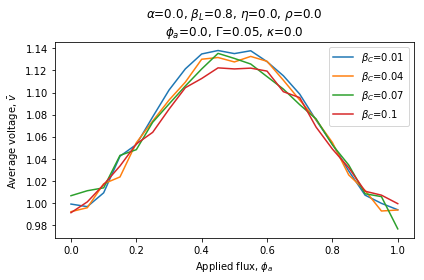

In [75]:
vphi_curve(nStep,tau,s,par,betaC=BetaC)

#### transfer function utility

It would be useful to draw the average voltage surface and related transfer function for a given set of parameters. Below is a function to to do so. It produces a time series for every point on a 2-d i-phia surface, takes the average voltage, and stores a 3-d surface. Then, some light smoothing is applied, and the transfer function surface is calculated. We simply take the partial derivative of the average voltage in the phia direction at every point on the average voltage surface. Both are plotted, both are saved out as csv files.

In [10]:
def transfer_fn(nStep,tau,s,par,i,phia):
    """Returns average voltage surface plot and csv
        and transfer function surface plot and csv
    DEPENDENCIES
        numpy as np
        scipy.interpolate
        qSQUID()
    INPUTS
        nStep - number of steps needed in timeseries
        tau - step size for time series
        s - initial state vector
            array[delta_1,delta_2]
        par - parameter vector
            array[alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
            alpha - resistance symmetry
            betaL - inductance constant
            eta - inductance symmetry
            rho - resistance symmetry
            i - bias current
            phia - applied mag flux
            Gamma - Johnson noise parameter
            betaC - capacitance constant
            kappa - capacitance symmetry
    OUTPUTS
        average voltage surface plot AveVsurf'datetime'.png
        average voltage surface csv AveVsurf'datetime'.csv
        transfer function surface plot TransferFn'datetime'.png
        transfer function surface csv TransferFn'datetime'.csv"""
    m = len(i)
    n = len(phia)
    l = int(nStep*.1)
    N = m*n
    vp = np.zeros([n,m])
    iv = np.zeros([m,n])
    
    # calculate average voltage surface
    for j in range(0,m):
        for k in range(0,n):
            par[4] = i[j]
            par[5] = phia[k]
            X = noisySQUID(nStep,tau,s,par)
            v = np.average(X[6,l:])
            vp[k,j] = v
            iv[j,k] = v
            update_progress((j*n+k)/(m*n))
    update_progress(1)
    
    ## smooth and interpolate over a grid lx dense ##
    l = 1
    inew = np.copy(i)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
    phianew = np.copy(phia)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

    x, y = np.meshgrid(phia,i)
    xnew, ynew = np.meshgrid(phianew,inew)
    z = np.copy(iv)
    tck = interpolate.bisplrep(y, x, iv, s=.05) # s = smoothing
    ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
    
    # find gradient of surface
    dv = np.gradient(ivi,inew,phianew)
    
    # filename stuff
    # build rest of metadata needed for csv
    meta1 = ['# Gamma=%s, alpha=%s, betaL=%s, eta=%s, rho=%s' %(par[6],par[0],par[1],par[2],par[3])]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    meta3 = ['# values shown are vbar, representing a surface in dimensions i (vertical) and phia (horizontal)']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='AveVsurface'+timeti+'.csv'
    pngtitle='AveVsurface'+timeti+'.png'
    
    # create, write, and save(close) average voltage surface csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(iv)
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot average voltage surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(i)
    y = np.copy(phia)
    x, y = np.meshgrid(y, x)
    z = np.copy(iv)
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'average voltage $\bar{v}$',
          title = r'$\bar{v}(i,\phi_a)$; $\Gamma$=%s,$\alpha$=%s,$\beta_L$=%s,$\eta$=%s' %(par[6],par[0],par[1],par[2])+'\n'+\
                    r'$\rho$=%s,$\beta_C$=%s,$\kappa$=%s' %(par[3],par[7],par[8]))
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    
    # modify file stuff to ouput transfer function surface
    meta3 = ['# values shown are dvbar/dphia, the transfer function in dimensions i (vertical) and phia (horizontal)']
    csvtitle='TransferFn'+timeti+'.csv'
    pngtitle='TransferFn'+timeti+'.png'
    
    # create, write, and save(close) transger function csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(dv[1])
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot transfer function
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(inew)
    y = np.copy(phianew)
    x, y = np.meshgrid(y, x)
    z = np.copy(dv[1]) # partial dvbar/dphia
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
          title = r'$\bar{v}(i,\phi_a)$; $\Gamma$=%s,$\alpha$=%s,$\beta_L$=%s,$\eta$=%s' %(par[6],par[0],par[1],par[2])+'\n'+\
                    r'$\rho$=%s,$\beta_C$=%s,$\kappa$=%s' %(par[3],par[7],par[8]))
    ax.view_init(65,-60)
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    return(iv)

#### transfer function utility

We need to supply the simulation parameters **nStep** and **tau**, the number of steps and the step size. We need to supply the initial state vector, **s** representing the initial phase differences 1 and 2, and the first and second time derivatives of each. We need to supply the physical parameters as values of the parameter vector as above.

We also need to supply the 2-d i-phia surface over which to look. We do this by supplying two 1-d arrays of i and phia as numpy arrays.

In [19]:
nStep = 16000
tau = 0.1
# s = array([delta_1,delta_2,ddelte_1,ddelta_2,d^2delta_1,d^2delta_2])
s = np.array([0.,0.,0.,0.,0.,0.])
alpha = 0.
betaL = 1.
eta = 0.
rho = 0.
Gamma = 0.05
betaC = .3
kappa = .5
i = np.arange(-3.,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(-1.,1.1,.1)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)
par = np.array([alpha,betaL,eta,rho,0.,0.,Gamma,betaC,kappa])

Progress: [####################] 100.0%
csv file written out: AveVsurface20191130215109.csv
png file written out: AveVsurface20191130215109.png
csv file written out: TransferFn20191130215109.csv
png file written out: TransferFn20191130215109.png


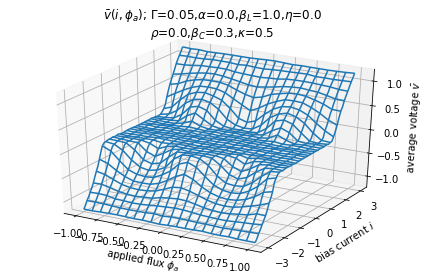

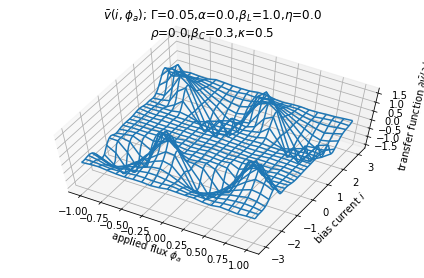

In [20]:
Vsurf = transfer_fn(nStep,tau,s,par,i,phia)

Below are the code snippets used to develop the method above, for further consideration.

In [ ]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 64000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
beta = 1.
eta = 0.
rho = 0.
Gamma = 0.05
i = np.arange(0.8,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(0.,.55,.025)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)

In [ ]:
i.shape

In [ ]:
%%time 
# cell magic timer to see how long this takes...
m = len(i)
n = len(phia)
l = int(nStep*0.05)
N = m*n
vp = np.zeros([n,m]) # average v at fixed phia
iv = np.zeros([m,n]) # average v at fixed i

for j in range(0,m):
    for k in range(0,n):
        X = noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i[j],phia[k],Gamma)
        v = np.average(X[6,l:]) # average voltage
        vp[k,j] = v 
        iv[j,k] = v

In [ ]:
#np.savetxt("test.csv", vp, delimiter=",")
#np.savetxt("test.csv", iv, delimiter=",")
#vp = np.genfromtxt('vp.csv',delimiter=',')
#iv = np.genfromtxt('iv.csv',delimiter=',')

In [ ]:
fig = plt.figure(figsize=[9,6])

ax1 = plt.subplot(1,2,1)
ax1.plot(phia,vp[:,0],label=round(i[0],2))
for h in range(1,len(vp[0,:])):
    ax1.plot(phia,vp[:,h],label=round(i[h],2))
ax1.set(title=r'$i(\bar{v},\phi_a)$',
        xlabel=r'applied flux $\phi_a$',
        ylabel=r'average voltage $\bar{v}$')
ax1.legend(loc=6,title=r'$\phi_a$')

ax2 = plt.subplot(1,2,2)
ax2.plot(vp[0,:],i,label=round(phia[0],3))
for h in range(1,len(vp[:,0])):
    ax2.plot(vp[h,:],i,label=round(phia[h],3))
ax2.set(title=r'$\phi_a(\bar{v},i)$',
        xlabel=r'average voltage $\bar{v}$',
        ylabel=r'bias current $i$')
ax2.legend(title=r'$i$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
plt.plot(phia,vp[:,0],label=round(i[0],2))
plt.plot(phia,vp[:,4],label=round(i[4],2))
plt.plot(phia,vp[:,8],label=round(i[8],2))
plt.plot(phia,vp[:,12],label=round(i[12],2))
plt.plot(phia,vp[:,16],label=round(i[16],2))
plt.plot(phia,vp[:,20],label=round(i[20],2))
#for h in range(1,len(vp[0,:])):
    #plt.plot(phia,vp[:,h],label=round(i[h],2))
plt.title(r'$i(\bar{v},\phi_a)$')
plt.xlabel(r'applied flux $\phi_a$')
plt.ylabel(r'average voltage $\bar{v}$')
plt.legend(loc=6)

In [ ]:
plt.plot(vp[0,:],i,label=round(phia[0],3))
plt.plot(vp[10,:],i,label=round(phia[10],3))
plt.plot(vp[20,:],i,label=round(phia[20],3))
#for h in range(1,len(vp[:,0])):
    #plt.plot(vp[h,:],i,label=round(phia[h],3))
plt.title(r'$\phi_a(\bar{v},i)$')
plt.xlabel(r'average voltage $\bar{v}$')
plt.ylabel(r'bias current $i$')
plt.legend()

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(i)
y = np.copy(phia)
x, y = np.meshgrid(y, x)
z = np.copy(iv)
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
## smooth and interpolate over a grid lx dense ##
l = 1
inew = np.arange(0.8,3.1,0.1/l)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
phianew = np.arange(0.,.55,.025/l)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

x, y = np.meshgrid(phia,i)
xnew, ynew = np.meshgrid(phianew,inew)
z = np.copy(iv)
tck = interpolate.bisplrep(y, x, iv, s=.00) # s = smoothing
ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
ivi.shape

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#x = np.copy(i)
#y = np.copy(phia)
#x, y = np.meshgrid(y, x)
#z = np.copy(ivi)
ax.plot_wireframe(xnew, ynew, ivi) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [ ]:
## Transfer function ##
# need partial dvbar/dphia as a function of i
# that is the transfer function

# first get derivative of surface vbar(i,phia)
# gradient() returns one surface of the value of the partial deriv
# for each dependent dimension. So two sets for us: dvbar/di and 
# dvbar/dphia. We are interested in the second here.


dv = np.gradient(ivi,inew,phianew) # bingo, dv[1] = dvbar(i,phia)/dphia
                     # dv[0] = dvbar(i,phia)/di

# Next we can peep the surface

In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(inew)
y = np.copy(phianew)
x, y = np.meshgrid(y, x)
z = np.copy(dv[1]) # partial dvbar/dphia
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
      title = r'$\partial\bar{v}(i,\phi_a)/\partial\phi_a$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
ax.view_init(65,-60)
fig.tight_layout()
fig.savefig('test.jpg')

# This looks correct to me

In [ ]:
fig, ax = plt.subplots()
dv1 = np.copy(dv[1])
ax.plot(inew,dv1[:,int(5*l)],label=round(phianew[int(5*l)],3))
ax.plot(inew,dv1[:,int(10*l)],label=round(phianew[int(10*l)],3))
ax.plot(inew,dv1[:,int(-6*l)],label=round(phianew[int(-6*l)],3))
ax.set(title=r'$\partial \bar{v}(i,\phi_a)/\partial\phi_a$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$',
      xlabel=r'bias current, $i$',
      ylabel=r'transfer function, $(\partial\bar{v}/\partial\phi_a)_i$')
ax.legend(title=r'$\phi_a$')
fig.tight_layout()